# Get Data For Route Finder 2.0

In [123]:
import os
import pandas 
import numpy
import geopandas
from shapely.geometry import Point
from geopandas import GeoSeries
import json
import osmnx as ox
import matplotlib.pyplot as plt

''' LOCAL IMPORTS'''

from LOCAL.myAPIs import census_API_key as key
from getPop_df import makeAPI_PopByBlock2010
from downloadGEOdata import Download_Unzip_GEOs
from joinBlockPopGEOs import joinDFs
from AoA import makeBoundary
from Intersections import getIntersections, IntersectionsPerBlock, BlocksPerIntersection 
from MakeStops import MakeStops
from CurrentSystem import CurrentStops
from Reduce import filterStops
from GetPopMetric import Population

''' PROJECTIONS FOR AUSTIN TX '''

NAD83 = {'init': 'EPSG:2277'} # Texas North Central measurements in U.S. FEET

LatLong = {'init': 'EPSG:4326'}


[NAD83 Texas North Central Datum](http://spatialreference.org/ref/epsg/2277/)

## Get Population Data by Census City Block 

[US Census API User Guide](https://www.census.gov/data/developers/guidance/api-user-guide.Available_Data.html)

[TIGERweb API Docs](https://www.census.gov/data/developers/data-sets/TIGERweb-map-service.html)

In [2]:
key = key()
#state = str(input('enter state FIPS code (i.e. 48 for TX): '))
#county = str(input('enter county FIPS code (i.e. 453 for Travis): '))
state = 48
county = 453

In [3]:
df = makeAPI_PopByBlock2010(state, county, key)

In [4]:
df.head()

,population,state,county,tract,block
ID,,,,,
484530001011000,47,48,453,000101,1000
484530001011001,0,48,453,000101,1001
484530001011002,0,48,453,000101,1002
484530001011003,0,48,453,000101,1003
484530001011004,56,48,453,000101,1004


In [5]:
type(df.population[0])

str

In [6]:
df['population'] = df.population.astype('int')

In [7]:
type(df.population[0])

numpy.int64

In [8]:
df.shape

(15922, 5)

## Download Block-level shapefiles for State and Join DataFrames

The downloaded data includes census block shapes for the entire state specified. This may take a while to download, unzip, and transform. 

In [9]:
BlockGeoPath = 'LOCAL/blockGEOs_48'
df = joinDFs(BlockGeoPath, df)

GeoDataFrame with projection = {'init': 'epsg:4269'}


In [10]:
df.head()

,geometry,population,state,county,tract,block
ID,,,,,,
484530001011000,"POLYGON ((-97.755461 30.332333, -97.755298 30....",47,48,453,000101,1000
484530001011001,"POLYGON ((-97.75538399999999 30.335395, -97.75...",0,48,453,000101,1001
484530001011002,"POLYGON ((-97.75529899999999 30.335556, -97.75...",0,48,453,000101,1002
484530001011003,"POLYGON ((-97.75564899999999 30.330971, -97.75...",0,48,453,000101,1003
484530001011004,"POLYGON ((-97.74673799999999 30.326454, -97.74...",56,48,453,000101,1004


### Re-Project to GPS - NAD83 in U.S. FEET

In [11]:
df = df.to_crs(NAD83)

In [12]:
df.crs

{'init': 'EPSG:2277'}

## Define the Boundary of the Area of Analysis (AoA) 

Define the boundary with a list of census tracts that make up the area of analysis. 

For the City of Austin, [here](https://www.austintexas.gov/sites/default/files/files/Planning/Demographics/census_2010_tracts_core.pdf) is a PDF file of Census Tracts.

In [13]:
# For this demonstration, AoA is the East Side of Ausin, TX
AoA_tracts = ['001000','000902','000901','000804','000801','000802','000803','002109','002110','002111']
AoA_df = df[(df.tract.isin(AoA_tracts))]

In [58]:
AoA_df.crs

{'init': 'EPSG:2277'}

/home/schmidta/anaconda3/envs/TEST_fiona/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


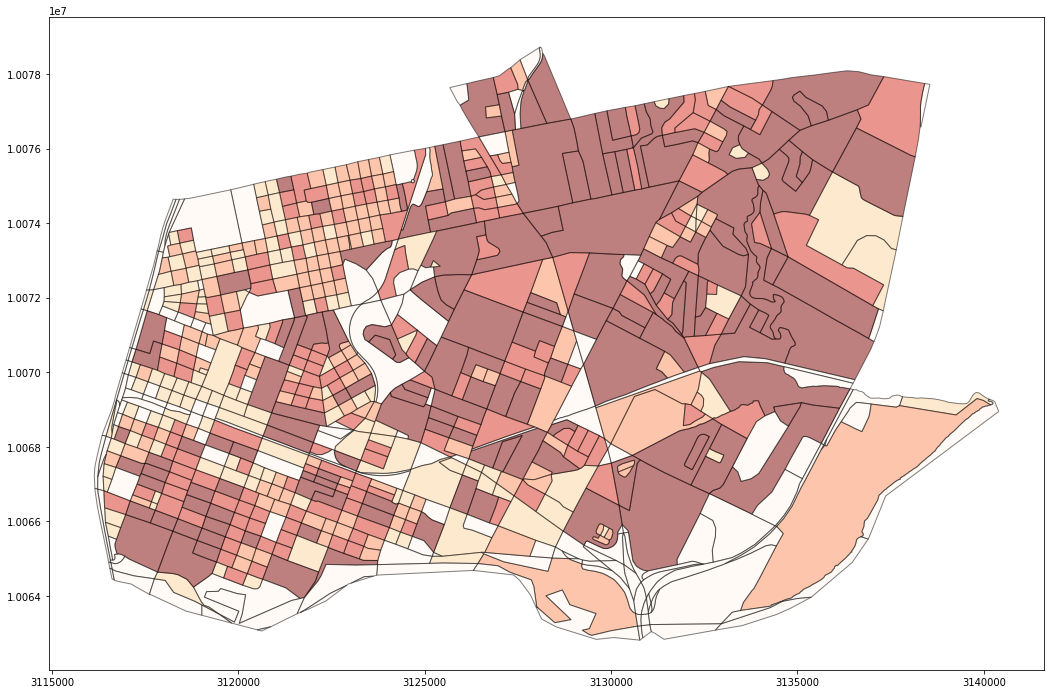

In [14]:
fig, ax = plt.subplots(figsize=(18,12))
ax.set_aspect('equal')
AoA_df.plot(ax=ax, column='population', cmap='OrRd', edgecolor='black', alpha=.5, scheme='quantiles')
plt.show()

### Make AoA Boundary (In Ft.)

In [59]:
AoA_geo = makeBoundary(AoA_df, NAD83)

In [60]:
AoA_geo.crs

{'init': 'EPSG:2277'}

In [61]:
bounds = AoA_geo.bounds
bounds

,minx,miny,maxx,maxy
0,3.116133e+06,1.006281e+07,3.140396e+06,1.007872e+07


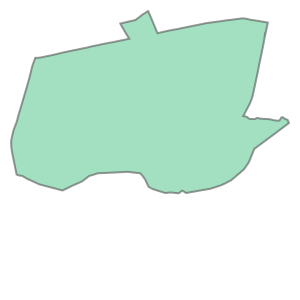

In [62]:
AoA_geo[0]

### Export Boundary

In [63]:
path = 'LOCAL/AoA_Boundary'
if not os.path.exists(path):
    os.makedirs(path)
AoA_geo.geometry.to_file(path)

## Get Intersections and Road Network Data using AoA Boundary

--> OSMNX Library Requires Projections to be in Lat Long Coordinates

In [66]:
AoA_LatLong = AoA_geo.to_crs(LatLong)
AoA_LatLong.crs

{'init': 'EPSG:4326'}

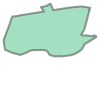

In [71]:
AoA_LatLong_geo = AoA_LatLong.geometry[0]
AoA_LatLong_geo

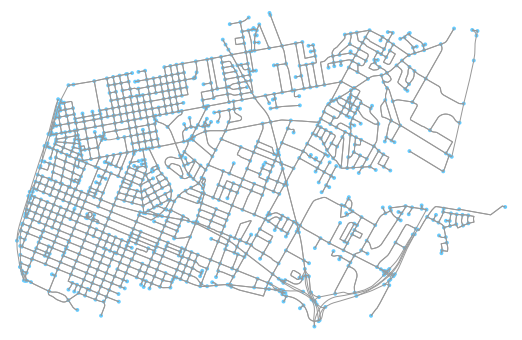

In [72]:
intersections = getIntersections(AoA_LatLong_geo, NAD83)

Read about [`clean_intersections()`](https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=clean_intersections) 

*note: distances are in meters

In [25]:
type(intersections)

geopandas.geoseries.GeoSeries

In [26]:
intersections.head()

0     POINT (3130804.345327734 10063238.7659741)
1     POINT (3131315.56998964 10064201.14206027)
2    POINT (3131025.934527216 10063525.66121256)
3     POINT (3118788.757601531 10064234.6072428)
4    POINT (3130248.937627049 10064251.94456208)
dtype: object

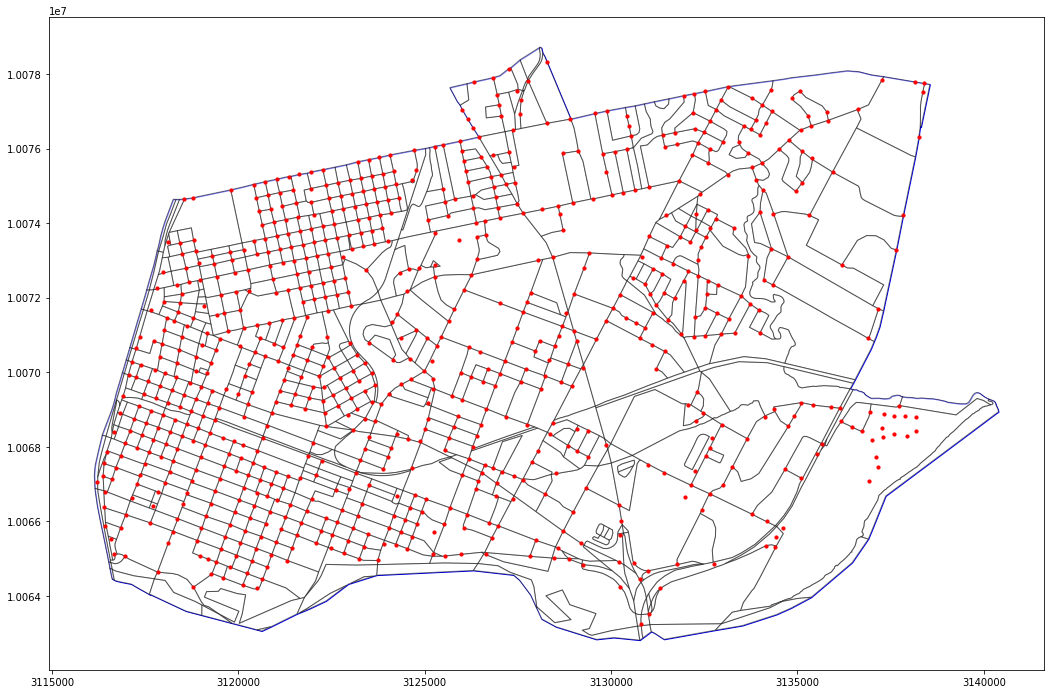

In [27]:
fig, ax = plt.subplots(figsize=(18,12))
ax.set_aspect('equal')
AoA_geo.plot(ax=ax, color='white', edgecolor='b')
AoA_df.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
intersections.plot(ax=ax, color='red', markersize=10)
plt.show()

## Calculate Population Metric for each intersection

Find all the census blocks connected to an intersection and sum up their populations. This metric will be the weight assigned to each intersection

In [28]:
AoA_df.head()

,geometry,population,state,county,tract,block
ID,,,,,,
484530008011000,"POLYGON ((3128165.889933975 10073028.87313997,...",26,48,453,000801,1000
484530008011001,"POLYGON ((3126259.905515095 10072617.07469161,...",54,48,453,000801,1001
484530008011002,"POLYGON ((3128786.624250126 10071485.82559277,...",0,48,453,000801,1002
484530008011003,"POLYGON ((3127742.862405837 10071878.00454578,...",92,48,453,000801,1003
484530008011004,"POLYGON ((3127842.780881476 10072139.02614147,...",76,48,453,000801,1004


### Population Distribution

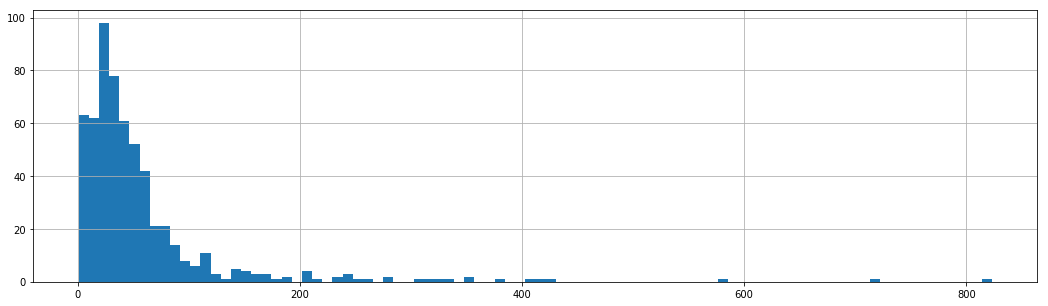

In [29]:
fig, ax = plt.subplots(figsize=(18,5))
AoA_df.population[AoA_df.population != 0].hist(bins=90)
#AoA_df.population.hist(bins=90)
plt.show()

In [30]:
intersections.head()

0     POINT (3130804.345327734 10063238.7659741)
1     POINT (3131315.56998964 10064201.14206027)
2    POINT (3131025.934527216 10063525.66121256)
3     POINT (3118788.757601531 10064234.6072428)
4    POINT (3130248.937627049 10064251.94456208)
dtype: object

### Convert to GeoDataFrame

In [31]:
intersections_df = geopandas.GeoDataFrame(intersections, columns=['geometry'], crs=NAD83)

In [32]:
intersections_df.head()

,geometry
0,POINT (3130804.345327734 10063238.7659741)
1,POINT (3131315.56998964 10064201.14206027)
2,POINT (3131025.934527216 10063525.66121256)
3,POINT (3118788.757601531 10064234.6072428)
4,POINT (3130248.937627049 10064251.94456208)


### BlocksPerIntersection()

In [33]:
intersections_df = BlocksPerIntersection(intersections_df, AoA_df)

In [34]:
intersections_df.head()

,geometry,bList,iPop
0,POINT (3130804.345327734 10063238.7659741),[POLYGON ((3126426.603570981 10064868.61706108...,25
1,POINT (3131315.56998964 10064201.14206027),"[POLYGON ((3131020.995685119 10063528.1449622,...",0
2,POINT (3131025.934527216 10063525.66121256),[POLYGON ((3130801.561764801 10063351.94860175...,0
3,POINT (3118788.757601531 10064234.6072428),[POLYGON ((3118793.869697565 10064236.14572304...,77
4,POINT (3130248.937627049 10064251.94456208),"[POLYGON ((3129772.358288543 10064943.1167959,...",25


### Zero Population Intersections

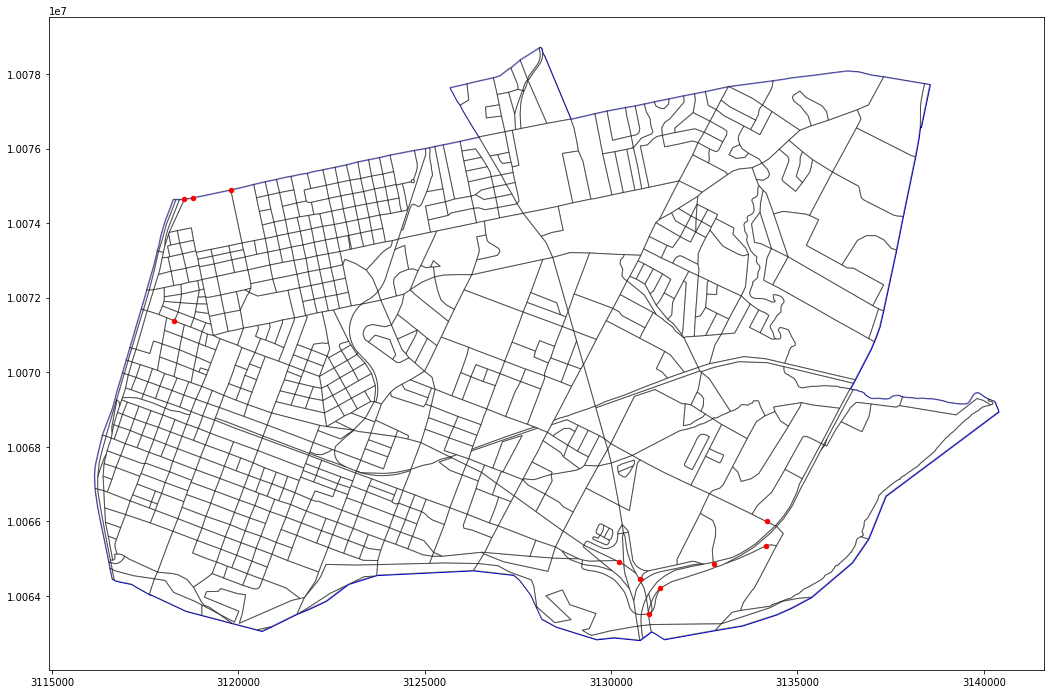

In [35]:
fig, ax = plt.subplots(figsize=(18,12))
ax.set_aspect('equal')
AoA_geo.plot(ax=ax, color='white', edgecolor='b')
AoA_df.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
intersections_df[intersections_df.iPop == 0].geometry.plot(ax=ax, color='red', markersize=20)
plt.show()

### High Population Intersections

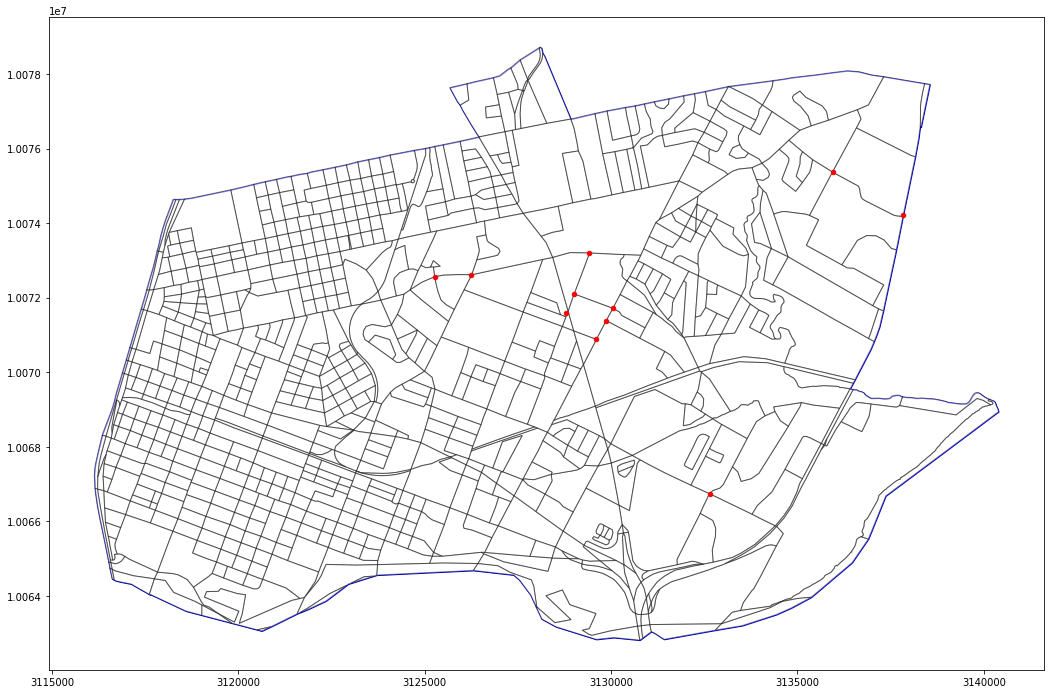

In [36]:
fig, ax = plt.subplots(figsize=(18,12))
ax.set_aspect('equal')
AoA_geo.plot(ax=ax, color='white', edgecolor='b')
AoA_df.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
intersections_df[intersections_df.iPop > 800].geometry.plot(ax=ax, color='red', markersize=20)
plt.show()

## Determine Bus Stop Locations

In [37]:
stops_df = MakeStops(intersections_df)
stops_df.head()

,geometry,bList,iPop,mergedPop
0,POINT (3130804.345327734 10063238.7659741),[POLYGON ((3126426.603570981 10064868.61706108...,25,25
3,POINT (3118788.757601531 10064234.6072428),[POLYGON ((3118793.869697565 10064236.14572304...,77,77
8,POINT (3117831.215609025 10064647.51036373),"[POLYGON ((3116687.532992585 10065400.490513, ...",383,383
10,POINT (3131778.263331682 10064848.41826016),[POLYGON ((3130214.600788716 10066429.88383338...,349,349
11,POINT (3130602.364981864 10064884.82393999),[POLYGON ((3130214.600788716 10066429.88383338...,349,723


In [38]:
stops_df.shape

(191, 4)

In [39]:
stops_df.crs

{'init': 'EPSG:2277'}

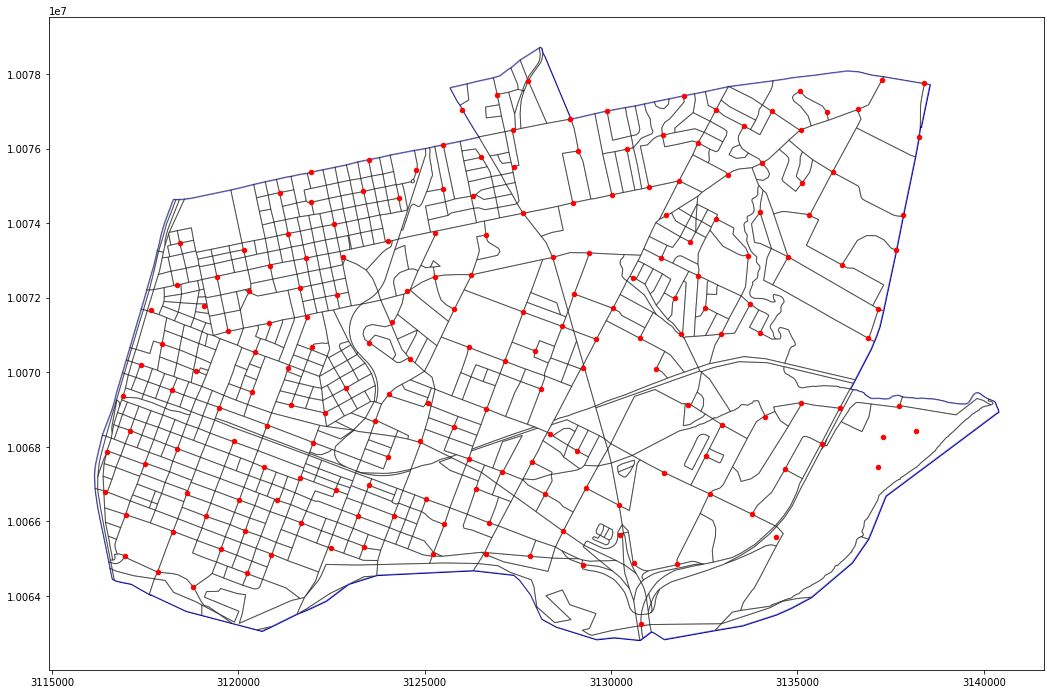

In [40]:
fig, ax = plt.subplots(figsize=(18,12))
ax.set_aspect('equal')
AoA_geo.plot(ax=ax, color='white', edgecolor='b')
AoA_df.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
stops_df.geometry.plot(ax=ax, color='red', markersize=20)
plt.show()

The bus stops identified by the algorith as-is would be an ideal scenario where everyone lives within 400 meters of a transit access point and does not take into account the inefficiencies of operating such a map. We need to filter this result to something more practical.

Lets look at the current Bus system for this region:

### Curent Bus System

[Routes, Stops, Park & Rides, ADA Polygons, and Service Area for the June 2018 Service Period](https://data.texas.gov/Transportation/Shapefiles-JUNE-2018/rwce-6ann)

In [41]:
stopsPathDBF = 'LOCAL/CapMetro/Stops.dbf'

In [42]:
CurrentStops_df = CurrentStops(stopsPathDBF, AoA_geo[0], NAD83)

In [43]:
CurrentStops_df.shape

(246, 18)

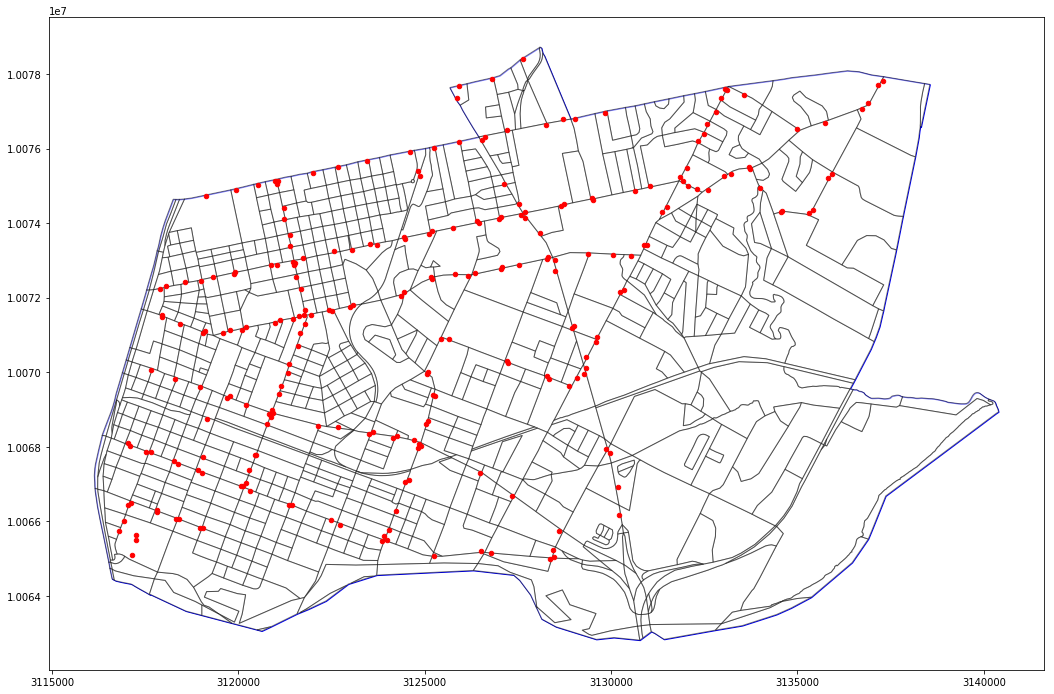

In [44]:
fig, ax = plt.subplots(figsize=(18,12))
ax.set_aspect('equal')
AoA_geo.plot(ax=ax, color='white', edgecolor='b')
AoA_df.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
CurrentStops_df.geometry.plot(ax=ax, color='red', markersize=20)
plt.show()

#### Distribution of Population Served by each stop

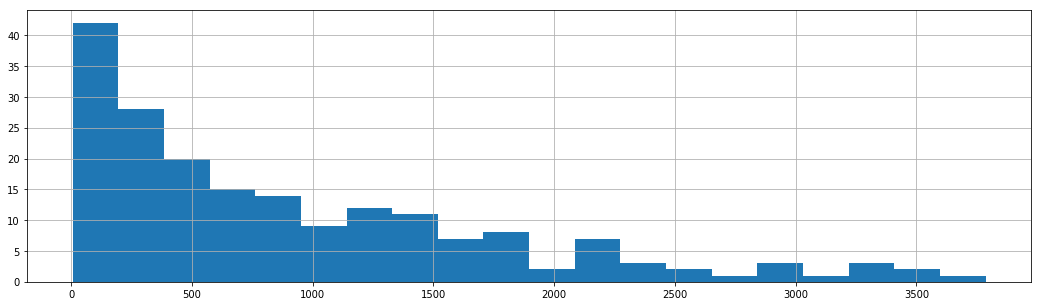

In [45]:
fig, ax = plt.subplots(figsize=(18,5))
stops_df.mergedPop.hist(bins=20)
plt.show()

In [46]:
filterStops_df, bench = filterStops(CurrentStops_df, stops_df)

In [47]:
filterStops_df.head()

,geometry,bList,iPop,mergedPop
8,POINT (3117831.215609025 10064647.51036373),"[POLYGON ((3116687.532992585 10065400.490513, ...",383,383
11,POINT (3130602.364981864 10064884.82393999),[POLYGON ((3130214.600788716 10066429.88383338...,349,723
44,POINT (3118234.526940965 10065726.15975965),[POLYGON ((3118375.710481537 10066071.13507968...,531,2414
48,POINT (3116948.056468503 10065063.88655742),"[POLYGON ((3116687.532992585 10065400.490513, ...",306,612
53,POINT (3119521.180218406 10065246.69401847),[POLYGON ((3119646.881295052 10065586.14605746...,228,1390


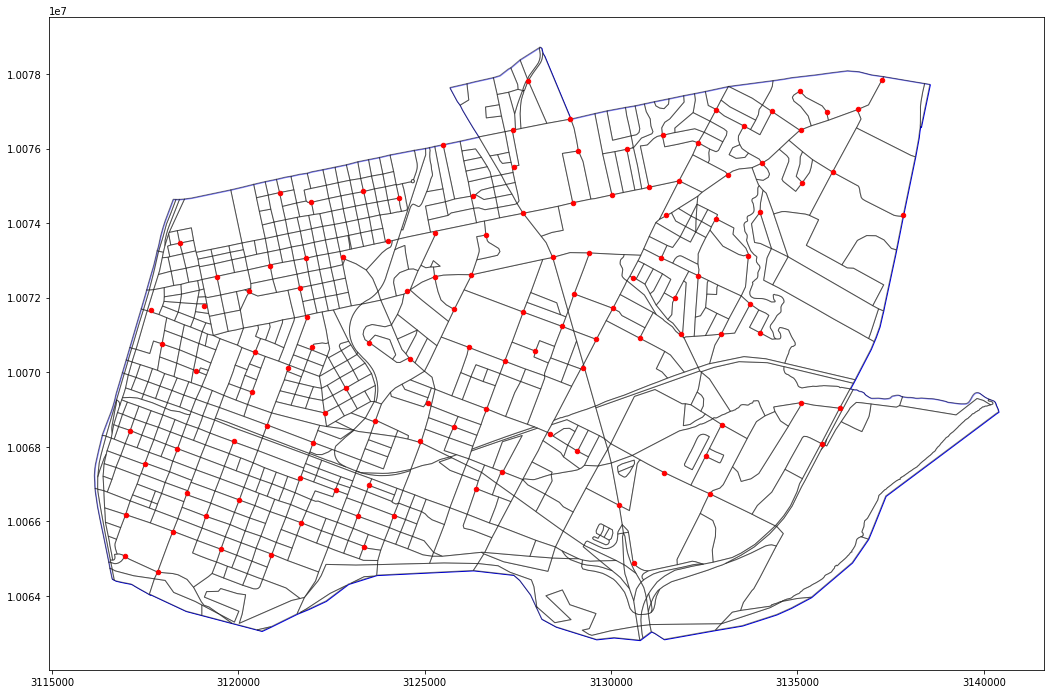

In [48]:
fig, ax = plt.subplots(figsize=(18,12))
ax.set_aspect('equal')
AoA_geo.plot(ax=ax, color='white', edgecolor='b')
AoA_df.plot(ax=ax, color='white', edgecolor='black', alpha=.5)
filterStops_df.geometry.plot(ax=ax, color='red', markersize=20)
plt.show()

### Locate Ideal Station Point

In [141]:
lat, long = 30.270043, -97.731517

In [142]:
def findNearestIntersection(lat, long, stops_df, crs):
    '''
    INPUT:  long (float) longitude
            lat (float) latitude
            stops_df (GeoDataFrame) bus stops
    
    OUTPUT: Point
    '''
    stationPoint = Point(lat, long)
    stationPoint.crs = {'init': 'EPSG:4326'}
    # Convert to GeoPandas so we can re-project crs to NAD83
    stationPoint = geopandas.GeoSeries(stationPoint, crs={'init': 'EPSG:4326'})
    stationPoint = stationPoint.to_crs(crs)
    
    for stop in stops_df.geometry:
        zone = stop.buffer(50)
        if stop.intersects(zone):
            return stop
        
    return 'No Stop Found'
        
    

In [143]:
station = findNearestIntersection(lat, long)

TypeError: findNearestIntersection() missing 2 required positional arguments: 'stops_df' and 'crs'

## Compare Stops - Current v. Proposed

1. Population of Region
2. Population within 1/4 mile of a stop

__Population of Region__

In [49]:
RegionPop = AoA_df.population.sum()
print('Region Population: ', RegionPop)

Region Population:  33184


__Population within 1/4 mile__

In [50]:
CurrentPop = Population(CurrentStops_df, AoA_df)

/home/schmidta/Desktop/GitHub/DSI_Project/RouteFinder2.0/GetPopMetric.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  blocks_df['fractionalArea'] = blocks_df.geometry.intersection(buffer400).area / blocks_df.geometry.area
/home/schmidta/Desktop/GitHub/DSI_Project/RouteFinder2.0/GetPopMetric.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  blocks_df['fractionalPop'] = blocks_df.population * blocks_df.fractionalArea


In [51]:
ProposedPop = Population(stops_df, AoA_df)

/home/schmidta/Desktop/GitHub/DSI_Project/RouteFinder2.0/GetPopMetric.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  blocks_df['fractionalArea'] = blocks_df.geometry.intersection(buffer400).area / blocks_df.geometry.area
/home/schmidta/Desktop/GitHub/DSI_Project/RouteFinder2.0/GetPopMetric.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  blocks_df['fractionalPop'] = blocks_df.population * blocks_df.fractionalArea


In [52]:
CurrentMetric = round(CurrentPop/RegionPop,2)
ProposedMetric = round(ProposedPop/RegionPop,2)
print('Current:', CurrentMetric*100,'% of the population is within 1/4 mile of a bus stop')
print('Proposed:', ProposedMetric*100,'%of the population is within 1/4 mile of a bus stop')

Current: 37.0 % of the population is within 1/4 mile of a bus stop
Proposed: 46.0 %of the population is within 1/4 mile of a bus stop


## Export Proposed Stops

In [53]:
path = 'LOCAL/proposedStops_eastSide'
if not os.path.exists(path):
    os.makedirs(path)
filterStops_df.geometry.to_file(path)